<a href="https://colab.research.google.com/github/zhus-dika/ts_forecasting/blob/master/HW3_TSForecasting_with_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HSE, Applied Time Series Forecasitng , Winter 2022-23 

<font color="blue"> Lesson #7: Time Series Forecasting with ML </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - demand forecasting, lagged features, time series CV

**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

# Demand Time Series

In [1]:
import os
import numpy as np
import math
import scipy as sc
import matplotlib.pyplot as plt

# Initialized Exponential Smoothing
# x <array Tx1>- pandas time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptationPeriod <int> - length of Adaptation period in timestamps

def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST	

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    # initialization
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = alpha*x[cntr] + (1-alpha)*y  # = y + alpha*(x[cntr]-y) 
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

def HoltExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    AdaptationPeriod = Params['AdaptationPeriod']
    
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    if beta>1:
        w.warn('beta can not be more than 1')
        #beta = 1
        return FORECAST
    if beta<0:
        w.warn('beta can not be less than 0')
        #beta = 0
        return FORECAST
    
    
    l= np.NaN
    b= np.NaN
    
    for t in range(T):
        if not math.isnan(x[t]):
            if math.isnan(l):
                l = x[t]
                b = x[t+1]-x[t]
                t0 = np.NaN
                
            l_prev = l    
                        
            if (t-t0+1)<AdaptationPeriod:
                l = (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))* x[t] + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*(l+b)
                b = (1-beta)*(t-t0+1)/(AdaptationPeriod)*(l - l_prev) + (1-alpha)*(t-t0+1)/(AdaptationPeriod)*b
            else:
                l = alpha* x[t] + (1-alpha)*(l+b)
                b = beta* (l - l_prev) + (1- beta)*b
                # b = beta* (x[t] - l_prev) + (1- beta)*b


        FORECAST[t+h] = l+ b*h
    return FORECAST
	
def AdditiveWintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if len(s)==0:
                # looking in the future
                for i in range(p):
                    s.append(x[i])
            if cntr<p:
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*l # recurrent smoothing of level 
            else:
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*l # recurrent smoothing of level 
                
        FORECAST[cntr+h] = l + s[cntr+h-(1+h//p)*p]
    return FORECAST


def TheilWageExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    b=np.NaN
    s= []
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= x[cntr]
            if math.isnan(b):
                b= 0
            
            if len(s)==0:
                for i in range(p):
                    s.append(x[i])
                    
                    
            if cntr<p:
                l_old=l
                l = alpha*(x[cntr]-s[cntr])+(1-alpha)*(l+b)
                b=beta*(l-l_old)+(1-beta)*b
            else:
                l_old=l
                s.append(gamma*(x[cntr]-l)+(1-gamma)*s[cntr-p])
                l = alpha*(x[cntr]-s[cntr-p])+(1-alpha)*(l+b) # recurrent smoothing of level 
                b=beta*(l-l_old)+(1-beta)*b
            
        FORECAST[cntr+h] = l+b + s[cntr+h - (1+h//p)*p]
    return FORECAST
	
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation
def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

# generate forecast values based on particular algorithm
# h - forecast horizon, each point in historical period will be forecasted with delay = h (h-step ahead)
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries, all of them will be forecasted independently
# AlgName - <str> name of the function that runs forecasting algorithm 
# AlgTitle <str> - a name of the forecasting algorithm
# step <char> - aggregation method of the original data before forecasting
# ParamsArray <array> - array of parameter set, each component of array defines particular forecasting algorithm
def build_forecast(h, ts, alg_name, alg_title, params_array, step='D'):
      
	FRC_TS = dict()

	for p in params_array:
		frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
		frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
	  
		for cntr in ts.columns:
			frc_ts[cntr] = eval(alg_name)(ts[cntr], h, p)

		#         frc_ts.columns = frc_ts.columns+('%s %s' % (alg_title, p))
		FRC_TS['%s %s' % (alg_title, p)] = frc_ts

	return FRC_TS

# draw forecast and original time series
# ts - <pandas data frame> with timestamps in index, each column contains particular timeseries
# frc_ts - <pandas data frame> the same structure as ts, 
# ts_num <int> - column index for which plot shoud be drawn
# alg_title <str> - a name of the forecasting algorithm
def plot_ts_forecast(ts, frc_ts, ts_num=0, alg_title=''):
	frc_ts.columns = ts.columns+'; '+alg_title
	ts[ts.columns[ts_num]].plot(style='b', linewidth=1.0, marker='o')
	ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
	plt.xlabel("Time ticks")
	plt.ylabel("TS values")
	plt.legend()
	return ax

# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y).abs()

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAPPE(x,y):
    # Mean absolute predicted percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/y.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualitySMAPE(x,y):
    # Symmetric mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAMAXPE(x,y):
    # Mean absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/max(x.abs(), y.max())).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMASE(x,y, init_step=0):
    # Mean absolute scaled error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/(x-x.shift(1)).abs())[init_step:].replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def qualityWAPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = x.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAPPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = y.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAMAXPE(x,y):
    # Weighted absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = pd.merge(x, y, right_index = True, left_index = True).max(axis = 1).sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()
	
def get_autoregrmatrix(x,h,K):
    T = len(x)
    X = sc.linalg.hankel(x[:T-h-K+1], 
                          np.hstack((x[T-h-K:T-h]))) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# don't forget to upload utils file to the colab session
#from utils import qualityWAPE, qualityRMSE
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [32]:
# загружаем данные
ts_retail = pd.read_csv('./train_kaggle.csv', sep=',')
ts_retail['Date'] = pd.to_datetime(ts_retail['Date'], dayfirst = True)
ts_retail.set_index(['Date'], inplace=True)
#ts_retail = ts_retail[:'2016-05-23']
ts_retail.sample(10)

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price
Date,,,,,,
2015-05-14,34,2,NaN,3,150.73,NaN
2015-05-20,12,2,NaN,3,158.34,NaN
2015-10-17,47,2,1.0,22,162.96,122.05
2015-10-11,87,1,1.0,456,141.21,130.21
2015-05-22,64,2,NaN,0,134.72,NaN
2015-08-01,25,2,NaN,0,134.72,NaN
2016-04-18,99,1,NaN,286,135.78,NaN
2016-03-13,82,1,1.0,261,141.21,132.92
2015-07-29,46,2,NaN,0,155.35,NaN


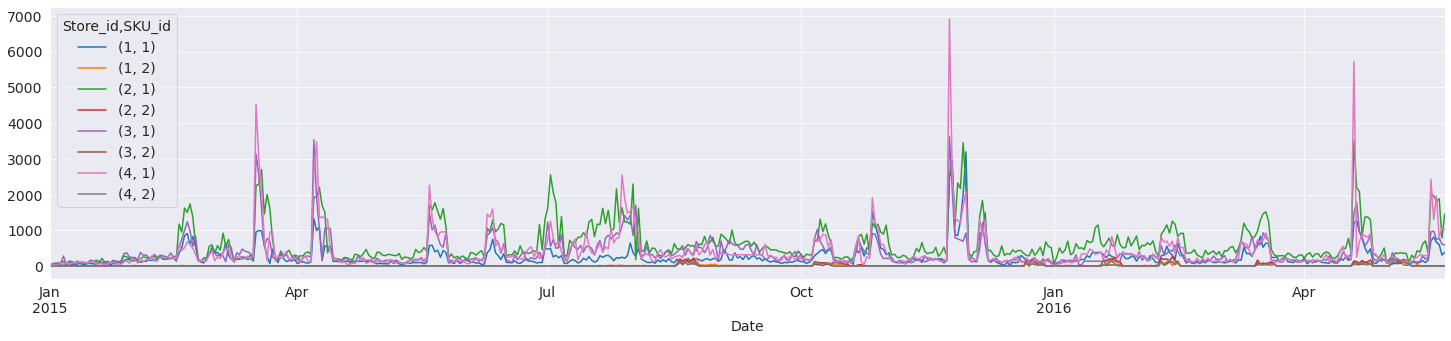

In [33]:
# Draw some time series
def plot_some_ts(ts_df, groupby_columns, time_column, target_column, ts_num = 10, aggregation_method = 'sum'):
  pivot_ts = ts_df.groupby(groupby_columns + [time_column]).agg(aggregation_method).\
     unstack(groupby_columns)[target_column]
  fig = pivot_ts[pivot_ts.columns[:ts_num]].plot()
  return fig


plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Demand', ts_num = 8);

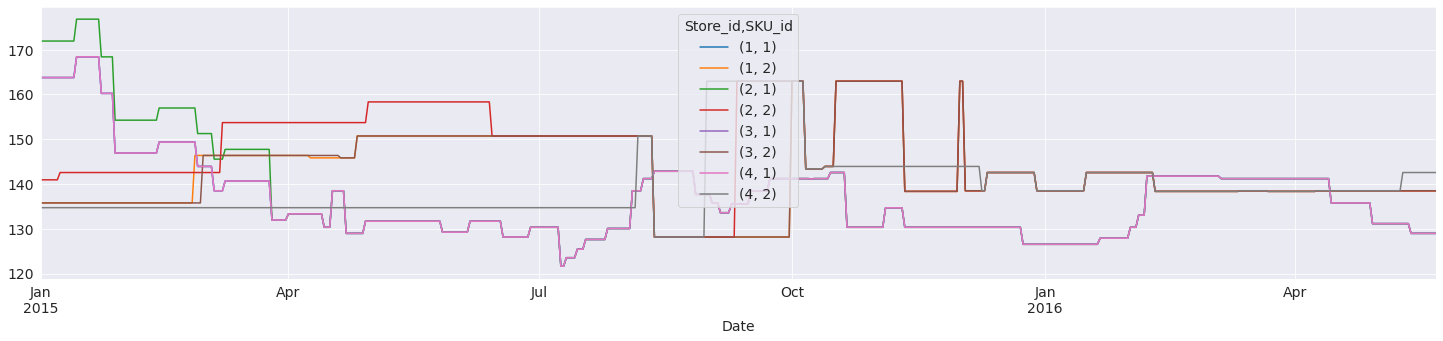

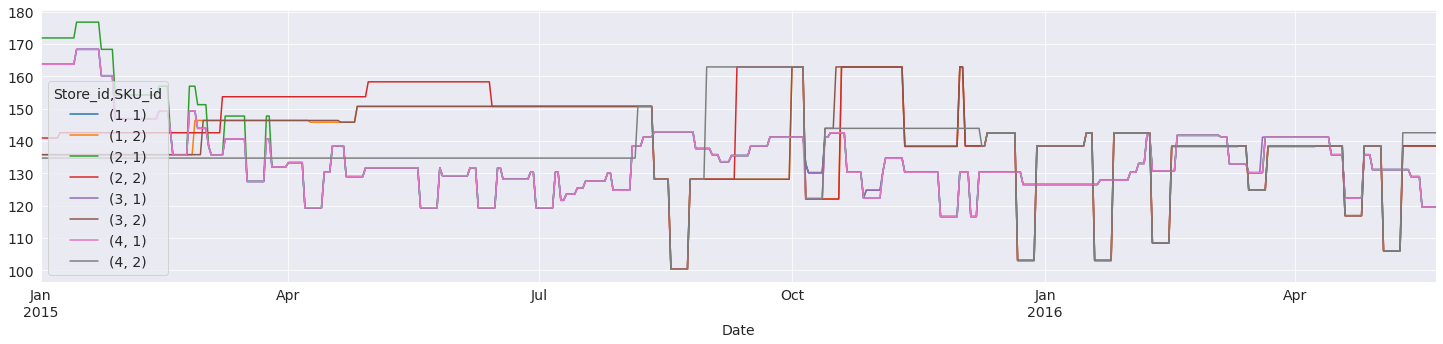

In [34]:
# Fill missings  (note: step is domain specific)
ts_retail['Promo'] = ts_retail['Promo'].fillna(0)
ts_retail.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
ts_retail['Regular_Price'] = ts_retail['Regular_Price'].ffill().bfill()
ts_retail.reset_index().set_index(['Date'], inplace=True)

plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Regular_Price', ts_num = 8);

# Add actual price (promo price when promo occurred or regular price otherwise)
ts_retail['Actual_Price'] = ts_retail.Promo_Price.combine_first(ts_retail.Regular_Price) 
plot_some_ts(ts_retail.reset_index(), ['Store_id','SKU_id'], 'Date', 'Actual_Price', ts_num = 8);

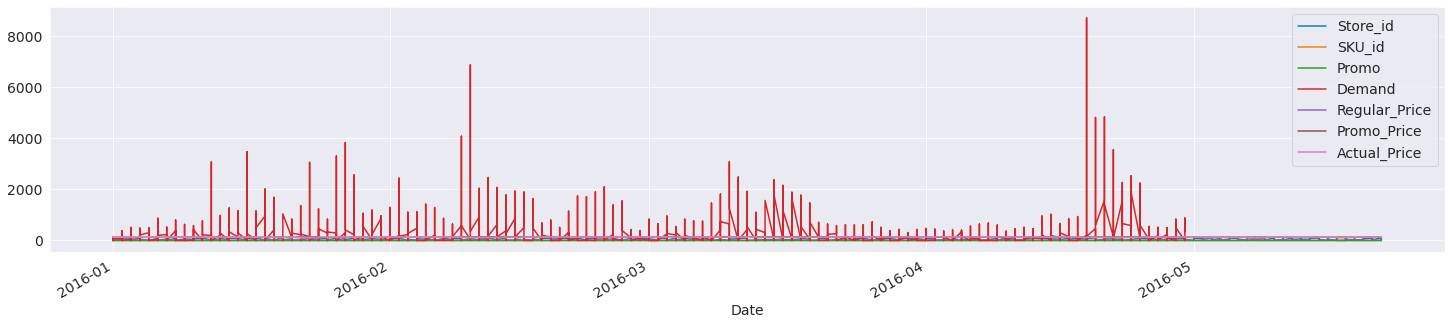

<Figure size 1800x360 with 0 Axes>

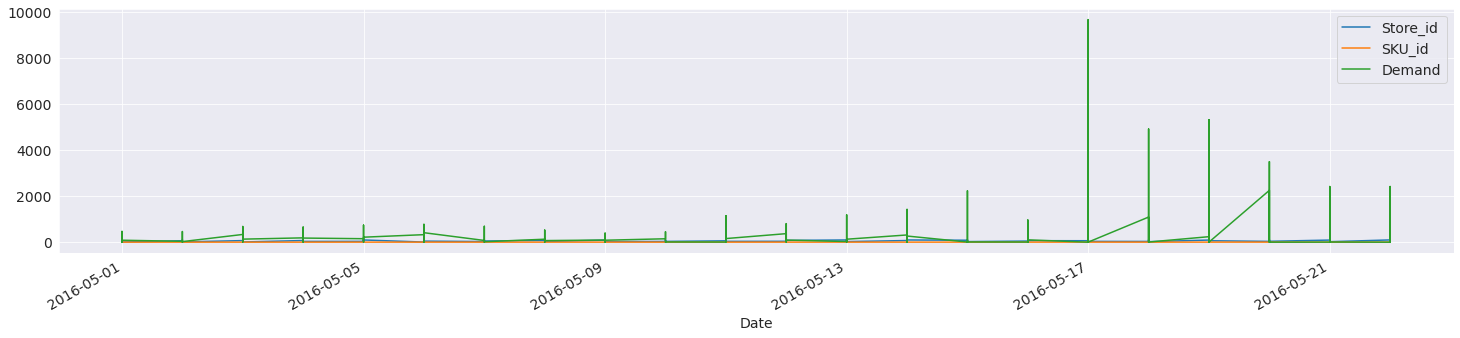

In [76]:
# prepare test/train datasets
test_start_dt = '2016-05-01'
train = ts_retail.copy(deep=True)
train.loc[test_start_dt:, 'Demand'] = np.NaN
train.loc['2016-01-01':].plot()
test_y = ts_retail.loc[test_start_dt:, ['Store_id', 'SKU_id', 'Demand']]

plt.figure();
test_y.plot();

In [37]:
test_y.shape

(4532, 3)

<AxesSubplot:xlabel='Date'>

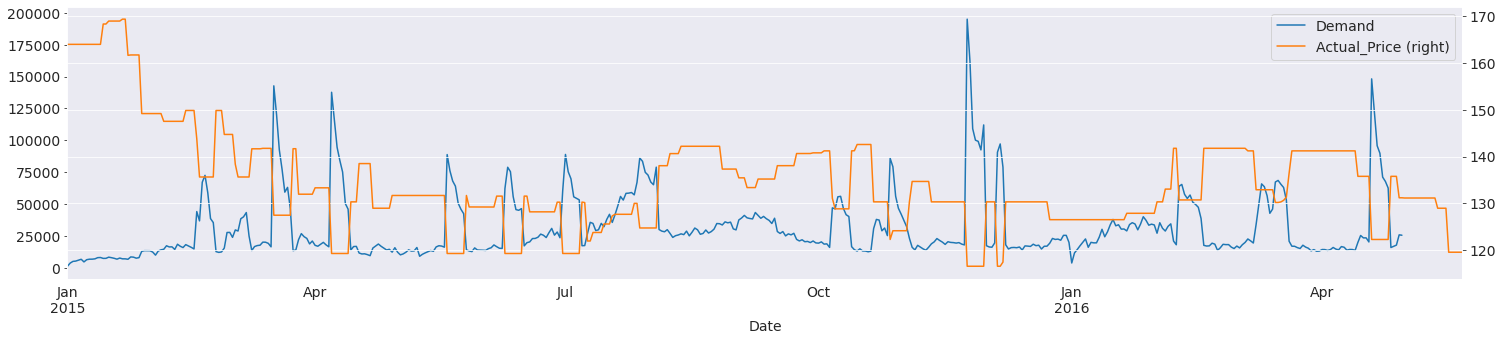

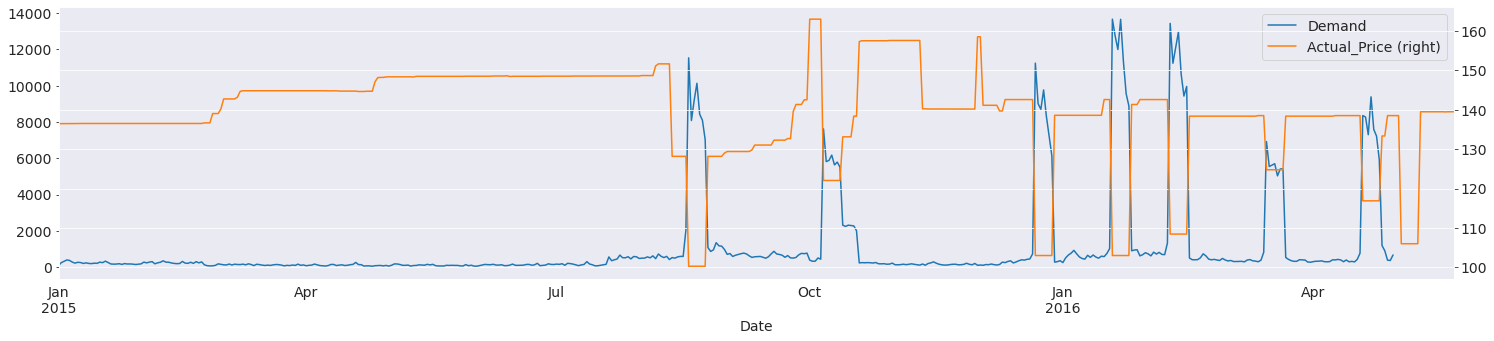

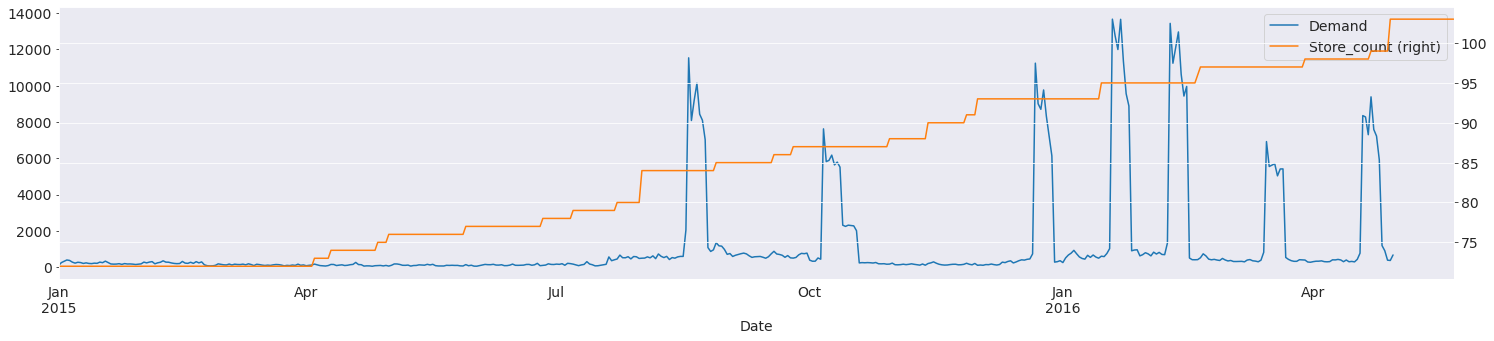

In [77]:
# Aggregate on Sku - All Stores level
sales_by_sku = train.groupby(['SKU_id','Date']).agg({'Demand':'sum','Promo':'sum','Store_id':'count','Actual_Price':'mean'}).reset_index().set_index('Date').rename(columns = {'Store_id':'Store_count'})
sales_by_sku.loc[test_start_dt:,'Demand'] = np.NaN # fill test period Demand with Nan

sales_by_sku[sales_by_sku['SKU_id'] == 1][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

sales_by_sku[sales_by_sku['SKU_id'] == 2][['Demand', 'Store_count']].plot(secondary_y = ['Store_count'])

# ML for time series Forecasting

**Questions**
* Can classic ML algorithms (including DT regressor, Boosting, RF regressors)   be applied to the ts forecasting problem?
  - Yes, assuming that ts model is defined properly

* How CV should be organized for ts problem?

<img src = 'https://miro.medium.com/max/753/1*qvdnPF8ETV9mFdMT0Y_BBA.png' width = '2500px'>

## Feature generation for ML algorithms
**Questions**
* What features should be added to the original data set?
   - Calendar-dummy variables: holidays, day of week, day of month
   - Lagged-features
   - x-sindicated features (e.g price x store_number**2)

In [78]:
# feature generation
data = sales_by_sku.reset_index().copy(deep = True)

data["weekday"] = data.Date.dt.weekday
data["monthday"] = data.Date.dt.day
data['is_weekend'] = data.weekday.isin([5,6])*1
data.head()

,Date,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1180.0,0.0,73,163.920685,3,1,0
1,2015-01-02,1,3667.0,0.0,73,163.920685,4,2,0
2,2015-01-03,1,4987.0,0.0,73,163.920685,5,3,1
3,2015-01-04,1,5226.0,0.0,73,163.920685,6,4,1
4,2015-01-05,1,5951.0,0.0,73,163.920685,0,5,0


### Lagged Features Generation

**Questions**
* Classic TS models leverage ts structure information (level, seasonaliry, trend, etc) for forecasting. How to provide such information for classsic ML models?

  - Answer: use ES forecast as features for ML  -->
     - Use more complicated ts based feature generation https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/
<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/LaggedFeaturesGeneration.PNG?raw=true'>

In [40]:
from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

# train[['SKU_id', 'Store_id', 'Demand']].groupby(['SKU_id', 'Store_id']).agg({'mean', 'std', percentile(50)})

# добавляем лаги
def lagged_features(df
                    , target_var = 'demand'
                    , org_id_columns = ['product_rk', 'store_location_rk']
                    , all_id_columns =['product_rk', 'store_location_rk', 'period_start_dt']
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , filters = None
                    ):
    '''Calculate lagged features '''
    ''' df - data frame
        target_var - column name which is used to calculate lagged features
        org_id_columns - id columns, lagged featires is calculated within each id element independatnly
        all_id_columns - id columns + timestamp column
        lags - 
        windows - list of windows, calculation is performed within time range length of window
        aggregation_methods - method of aggregation, e.g. 'mean', 'median', 'std', etc.
        filter = dict of dict: {<column_name>:{'postfix':'condition of the filter'}}
    '''
    out_df = deepcopy(df)

    if filters is None:
      filters = {'':{''}}

    keys, values = zip(*filters.items())
    for bundle in product(*values):
      # print(bundle)
        # define dates for each SKU and Store pairs        
      condition = ' & '.join([keys[i]+ filters[keys[i]][bundle[i]] for i in range(len(keys))])
      name =  '_'.join([bundle[i] for i in range(len(keys))])
      if len(condition) >0:
        _idx = df.eval(condition)
      else:
        _idx = df.index>=0
        
      if len(df[_idx].index)>0:
        for w in windows:
          lf_df = df[_idx].set_index(all_id_columns)[target_var].\
                    groupby(level=org_id_columns).apply(lambda x: x.rolling(window=w, min_periods = 1).agg(aggregation_methods))
          for l in lags:
            new_names = {x: "lag{0}_wdw{1}_{2}_{3}".
                          format(l, w, x, name) for x in lf_df.columns }

            out_df = pd.merge(out_df, lf_df.shift(l).reset_index().rename(columns = new_names),
                  how='left', on =all_id_columns )
            

    return out_df

In [79]:
from ipywidgets import IntProgress

from itertools import product
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_
    
# add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)

    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)

    results.index.rename(date_col, inplace=True)

    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation
    data_preag = data.groupby(group_col).agg(
        preagg_method)[target_cols].reset_index()

    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
        fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                    axis=1).reset_index()

    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):

    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):

    lf_df = lf_df_filled.groupby(
        level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df


def generate_lagged_features(
        data: pd.DataFrame,
        target_cols: list = ['Demand'],
        id_cols: list = ['SKU_id', 'Store_id'],
        date_col: str = 'Date',
        lags: list = [7, 14, 21, 28],
        windows: list = ['7D', '14D', '28D', '56D'],
        preagg_methods: list = ['mean'],
        agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
        dynamic_filters: list = ['weekday', 'Promo'],
        ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:
    
    ''' 
    data - dataframe with default index
    target_cols - column names for lags calculation
    id_cols - key columns to identify unique values
    date_col - column with datetime format values
    lags - lag values(days)
    windows - windows(days/weeks/months/etc.),
        calculation is performed within time range length of window
    preagg_methods - applied methods before rolling to make
        every value unique for given id_cols
    agg_methods - method of aggregation('mean', 'median', percentile, etc.)
    dynamic_filters - column names to use as filter
    ewm_params - span values(days) for each dynamic_filter
    '''

    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]

    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)

    for filter_col in dynamic_filters:
        group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                                    target_cols, preagg)

                ## add ewm features
                for alpha in ewm_params.get(filter_col, []):
                    ewm_filled = calc_ewm(data_preag_filled, group_col,
                                          date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
                        format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df,
                                      ewm.rename(columns=new_names),
                                      how='left',
                                      on=group_col)
                
                ## add rolling features
                for w in windows:
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled,
                                                      group_col, date_col,
                                                      method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col,
                                        lag)

                        method_name = method.__name__ if type(
                            method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df,
                                          rolling.rename(columns=new_names),
                                          how='left',
                                          on=group_col)
                        progress.value += 1

    return out_df

**Questions**
  * How to define lagges based on forecast horizon?
    - Lag must be less or equal than forecast horizon in order to prevent target leakage!
    - We are building forecast fot the next 22 days => minimal lag value is 22

In [81]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'
built_in_funcs = [pd.Series.kurtosis, pd.Series.skew]

# flts = {'Promo': {'oprm':'>0', 'npromo':'==0', 'aprm':'>-1'}, 'weekday' : {'md':'==0', 'tue':'==1', 'wd':'==2', 'th':'==3', 'fr':'==4', 'sa':'==5', 'su':'==6', 'anyday':'>-1'}}


data['NoFilter'] = 1
data_lagged_features = generate_lagged_features(data 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [22, 28, 35]
                    , windows = ['14D', '21D', '28D', '56D']
                    , preagg_methods = ['sum'] # ['mean', 'count']
                    , agg_methods = ['mean', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [14, 28], 'Promo': [14, 28]}
                    )

IntProgress(value=0, max=72)

In [82]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

94


Index(['Date', 'SKU_id', 'Demand', 'Promo', 'Store_count', 'Actual_Price',
       'weekday', 'monthday', 'is_weekend', 'NoFilter',
       'Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_alpha28_keySKU_id_preagsum_Promo_dynamic_ewm',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w14D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w21D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agmean_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agpctl10_Promo_dynamic_rolling',
       'Demand_lag22d_w28D_keySKU_id_preagsum_agpctl90_Promo_dynamic_rolling',
       'Demand_lag22d_w56D

## ML model definition
**Questions** 
* Shall we train only one model for all data?

<img src = 'https://github.com/aromanenko/ATSF/blob/main/pic/Informativity.png?raw=true'>

 See details here
http://www.machinelearning.ru/wiki/images/3/3e/Voron-ML-Logic.pdf

* Can we define ML pipeline based on business logics?

In [83]:
# put date in index
data_lagged_features.set_index('Date', inplace = True)
data_lagged_features.loc[test_start_dt:].head()

,SKU_id,Demand,Promo,Store_count,Actual_Price,weekday,monthday,is_weekend,NoFilter,Demand_lag22d_alpha14_keySKU_id_preagsum_Promo_dynamic_ewm,...,Demand_lag35d_w14D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w21D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w28D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agmean_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl10_NoFilter_dynamic_rolling,Demand_lag35d_w56D_keySKU_id_preagsum_agpctl90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,1,NaN,0.0,103,131.16,6,1,1,1,15025.884077,...,66737.0,39502.857143,15790.0,65777.0,34242.642857,15478.6,65611.1,33248.732143,15733.5,63728.5
2016-05-01,2,NaN,0.0,103,138.50,6,1,1,1,342.720725,...,5673.6,2152.904762,316.0,5619.0,1697.964286,306.7,5565.1,2495.071429,315.5,9691.5
2016-05-02,2,NaN,0.0,103,138.50,0,2,0,1,353.690913,...,5673.6,2157.952381,317.0,5619.0,1698.071429,306.7,5565.1,2489.125000,315.5,9691.5
2016-05-02,1,NaN,0.0,103,131.16,0,2,0,1,14857.320753,...,66737.0,39210.142857,15298.0,65777.0,34177.642857,15478.6,65611.1,33001.553571,15616.5,63728.5
2016-05-03,2,NaN,103.0,103,106.01,1,3,0,1,NaN,...,5595.9,2157.952381,317.0,5619.0,1699.857143,306.7,5565.1,2485.017857,315.5,9691.5


In [84]:
# train specific model for each SKU
sku1_train = data_lagged_features[data_lagged_features['SKU_id'] == 1]
sku2_train = data_lagged_features[data_lagged_features['SKU_id'] == 2]

## ML Model Training

In [85]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [103]:
train_end_dt = '2016-04-30'

In [104]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.loc[:train_end_dt].drop(['SKU_id','Demand'], axis=1), y = sku1_train.loc[:train_end_dt].Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.loc[:train_end_dt].drop(['SKU_id','Demand'], axis=1), y = sku2_train.loc[:train_end_dt].Demand)

LGBMRegressor(feature_fraction=0.7, metric='mae', n_estimators=500,
              num_leaves=40, subsample=0.4)

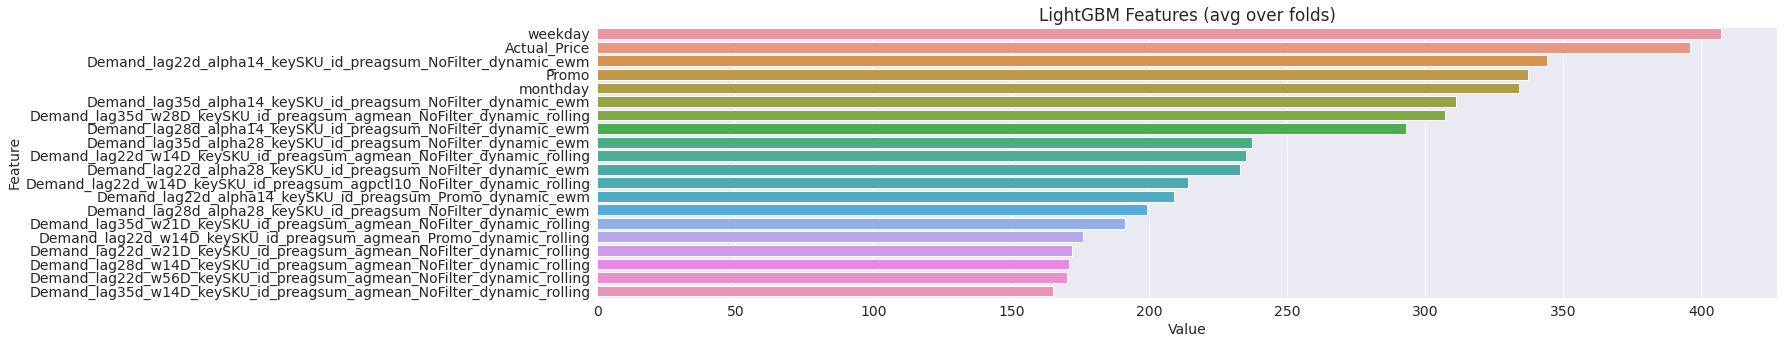

In [105]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[2:]], num = 20)

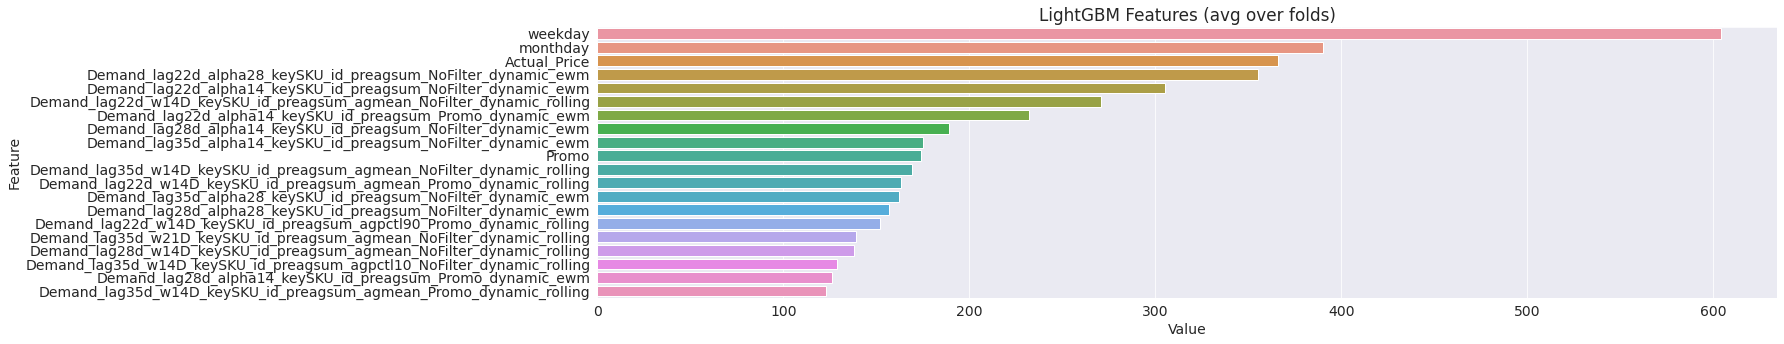

In [106]:
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[2:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [107]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [108]:
# Train sets
X_train1 = sku1_train.loc[:train_end_dt].drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.loc[:train_end_dt].Demand
X_train2 = sku2_train.loc[:train_end_dt].drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.loc[:train_end_dt].Demand

In [109]:
# test sets
X_test1 = sku1_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)
X_test2 = sku2_train.loc[test_start_dt:].drop(['SKU_id','Demand'], axis=1)

In [110]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [111]:
# run TS CV for the sku 1 (if needed)
#%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape, kwargs)

Size train set: (486, 91)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train and test: (56, 91)
[2]	valid_0's l1: 10998.9
[4]	valid_0's l1: 10998.9
[6]	valid_0's l1: 10998.9
[8]	valid_0's l1: 10998.9
[10]	valid_0's l1: 10998.9
[12]	valid_0's l1: 10998.9

Splitting the first 3 chunks at 2/3
Size of train and test: (84, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 23216.5
[4]	valid_0's l1: 22479.6
[6]	valid_0's l1: 22094
[8]	valid_0's l1: 21844.2
[10]	valid_0's l1: 21629.5
[12]	valid_0's l1: 21424.3
[14]	valid_0's l1: 21239.6
[16]	valid_0's l1: 21053.2
[18]	valid_0's l1: 20930.1
[20]	valid_0's l1: 20775.7
[22]	valid_0's l1: 20642.8
[24]	valid_0's l1: 20493.8
[26]	valid_0's l1: 20396.5
[28]	valid_0's l1: 20303.8
[30]	valid_0's l1: 20280.1
[32]	valid_0's l1: 20282.3
[34]	valid_0's l1: 20200.9
[36]	valid_0's l1: 20165.9
[38]	valid_0's l1: 20152.5
[40]	valid_0's l1: 2013

32.02709508485208

In [112]:
# run TS CV for the sku 2 (if needed)
#%%time
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape, kwargs)

Size train set: (486, 91)
Size of each fold: 28

Splitting the first 2 chunks at 1/2
Size of train and test: (56, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 222.772
[4]	valid_0's l1: 222.772
[6]	valid_0's l1: 222.772
[8]	valid_0's l1: 222.772
[10]	valid_0's l1: 222.772
[12]	valid_0's l1: 222.772

Splitting the first 3 chunks at 2/3
Size of train and test: (84, 91)
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[2]	valid_0's l1: 96.6216
[4]	valid_0's l1: 96.8845
[6]	valid_0's l1: 97.0537
[8]	valid_0's l1: 97.1759
[10]	valid_0's l1: 95.2537
[12]	valid_0's l1: 95.3845
[14]	valid_0's l1: 94.017
[16]	valid_0's l1: 94.107
[18]	valid_0's l1: 94.1936
[20]	valid_0's l1: 91.9368
[22]	valid_0's l1: 90.7583
[24]	valid_0's l1: 88.6263
[26]	valid_0's l1: 88.6967
[28]	valid_0's l1: 88.1996
[30]	valid_0's l1: 87.1698
[32]	va

40.127731141589265

## Forecast Generation with ML

<AxesSubplot:xlabel='Date'>

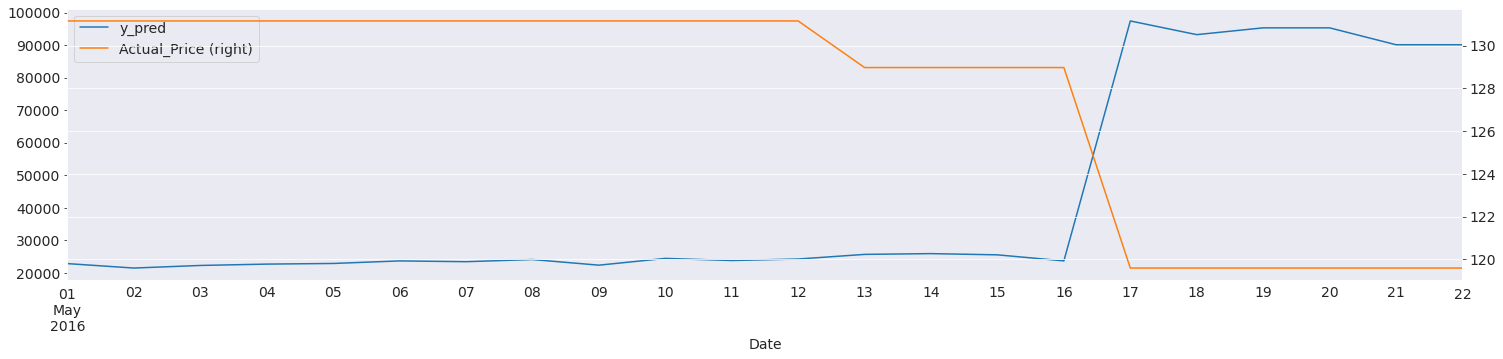

In [113]:
# forecast for sku 1
X_test1['y_pred'] = lgbm1.predict(X_test1)
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

<AxesSubplot:xlabel='Date'>

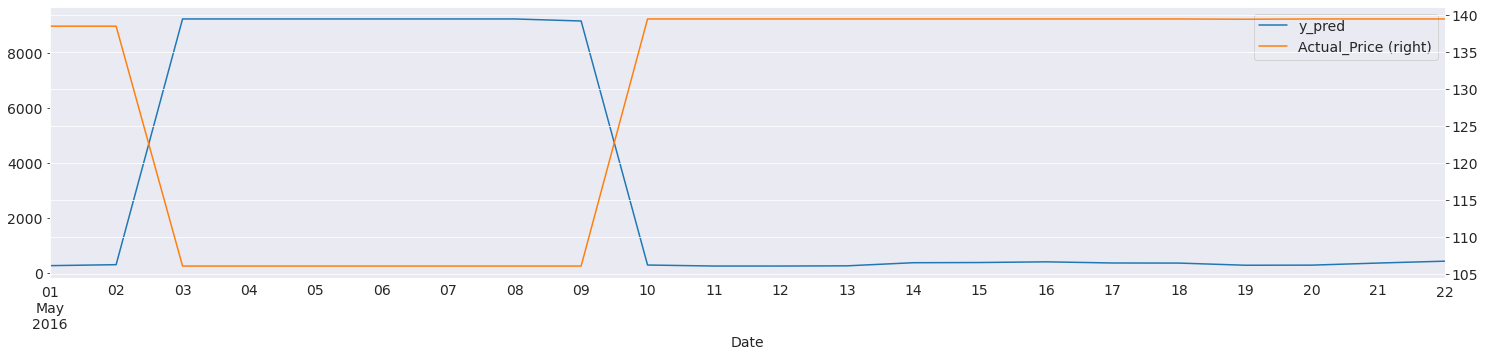

In [114]:
# forecast for sku 2
X_test2['y_pred'] = lgbm2.predict(X_test2)
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

**Note**: forecast highly depends on key drivers

<AxesSubplot:title={'center':'MAE=8431.93647019802'}, xlabel='Date'>

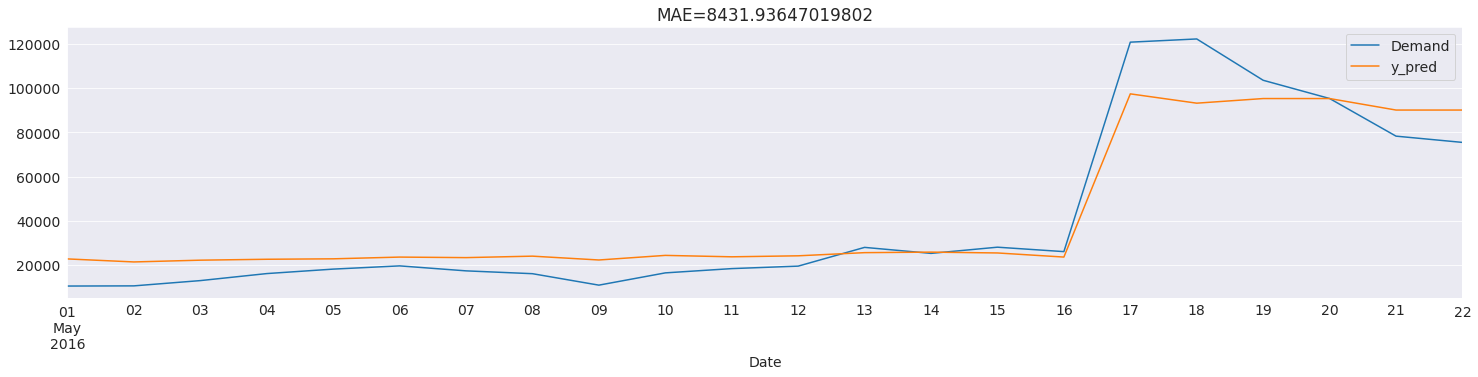

In [115]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityMAE(y_true[y_true['SKU_id']==1]['Demand'], X_test1['y_pred'])

#draw forecast and actuals
X_test1.merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'MAE='+str(qlt))


<AxesSubplot:title={'center':'MAE=1127.2842376731192'}, xlabel='Date'>

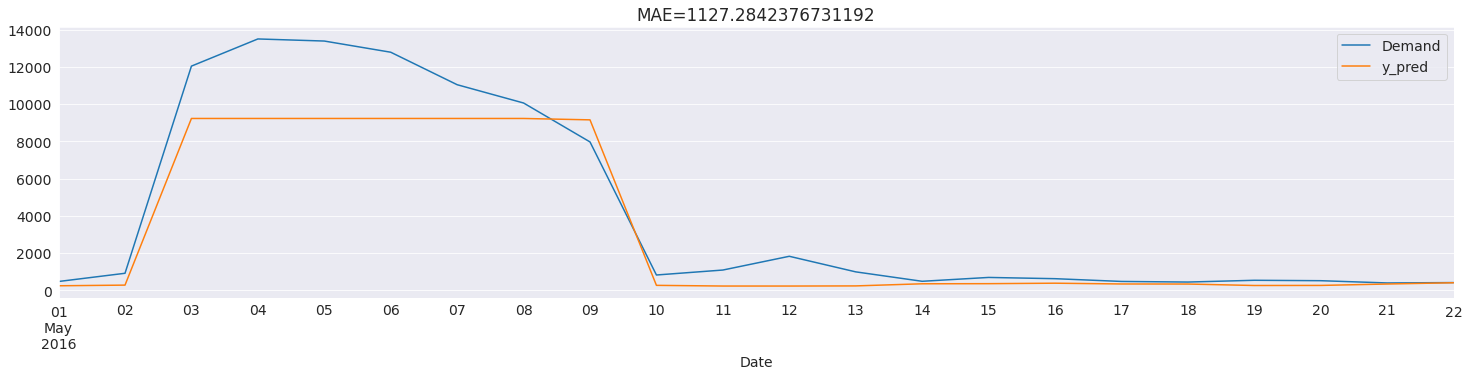

In [116]:
# MAE for sku 2
qlt , _ = qualityMAE(y_true[y_true['SKU_id']==2]['Demand'], X_test2['y_pred'])

#draw forecast and actuals
X_test2.merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'MAE='+str(qlt))


**Materials**
* Cross-validation for time series https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
* M - competition
  - M5: https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/163414
  - M4: https://www.sciencedirect.com/science/article/pii/S0169207019301128

In [117]:
# without CV
from catboost import Pool, CatBoostRegressor
catbst1 = CatBoostRegressor(
                        iterations=20,
                        learning_rate=1, 
                        loss_function='RMSE'
                        )
catbst1.fit(sku1_train.loc[:train_end_dt].drop(['SKU_id','Demand'], axis=1), 
            sku1_train.loc[:train_end_dt].Demand)

catbst2 = CatBoostRegressor(
                        iterations=20,
                        learning_rate=1, 
                        loss_function='RMSE'
                        )

catbst2.fit(sku2_train.loc[:train_end_dt].drop(['SKU_id','Demand'], axis=1), 
            sku2_train.loc[:train_end_dt].Demand)

0:	learn: 14732.5965312	total: 95.1ms	remaining: 1.81s
1:	learn: 11047.8106580	total: 108ms	remaining: 972ms
2:	learn: 9790.0757284	total: 117ms	remaining: 661ms
3:	learn: 9417.0558541	total: 123ms	remaining: 493ms
4:	learn: 8898.0387026	total: 129ms	remaining: 386ms
5:	learn: 7859.2950177	total: 134ms	remaining: 313ms
6:	learn: 7063.4176206	total: 139ms	remaining: 259ms
7:	learn: 6543.1587613	total: 145ms	remaining: 217ms
8:	learn: 5996.2811602	total: 150ms	remaining: 183ms
9:	learn: 5762.1525182	total: 155ms	remaining: 155ms
10:	learn: 5524.3336949	total: 160ms	remaining: 131ms
11:	learn: 5088.5879458	total: 166ms	remaining: 110ms
12:	learn: 4636.1328012	total: 171ms	remaining: 91.9ms
13:	learn: 4340.7514332	total: 176ms	remaining: 75.3ms
14:	learn: 4080.6392683	total: 181ms	remaining: 60.3ms
15:	learn: 3795.1125974	total: 186ms	remaining: 46.5ms
16:	learn: 3517.5017320	total: 191ms	remaining: 33.7ms
17:	learn: 3250.2909887	total: 196ms	remaining: 21.8ms
18:	learn: 3065.7055029	total

<AxesSubplot:xlabel='Date'>

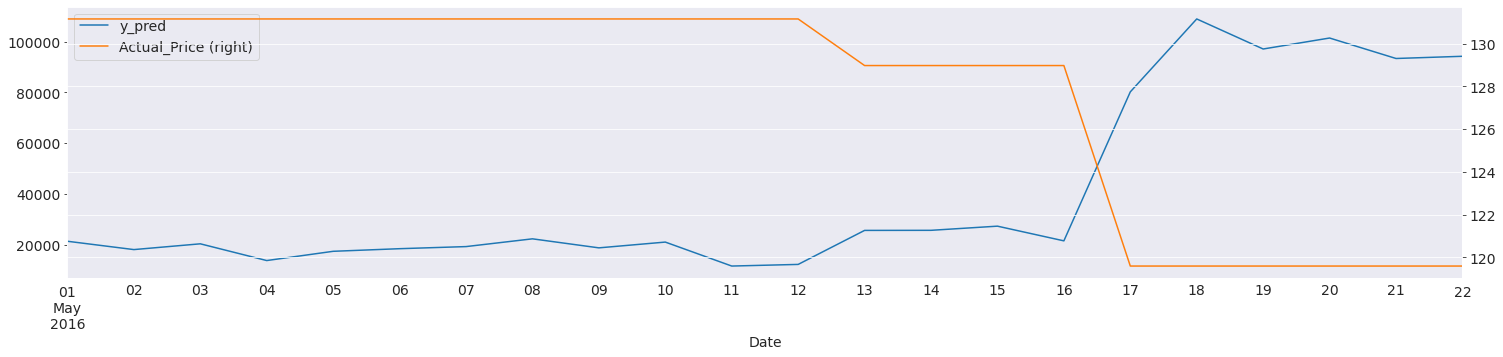

In [118]:
# forecast for sku 1
X_test1['y_pred'] = catbst1.predict(X_test1)
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

<AxesSubplot:title={'center':'MAE=7855.0448236569755'}, xlabel='Date'>

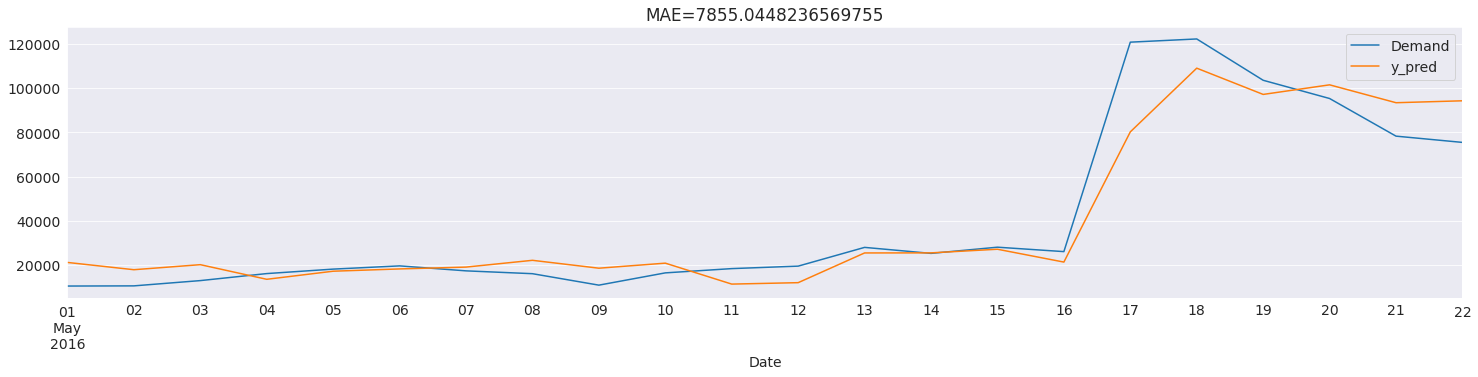

In [119]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityMAE(y_true[y_true['SKU_id']==1]['Demand'], X_test1['y_pred'])

#draw forecast and actuals
X_test1.merge(y_true[y_true['SKU_id']==1], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'MAE='+str(qlt))

<AxesSubplot:xlabel='Date'>

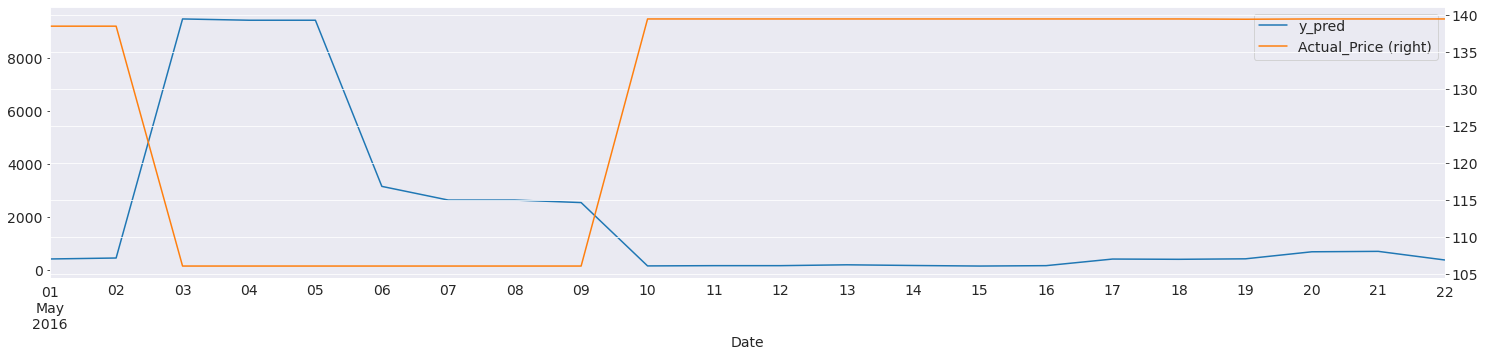

In [120]:
# forecast for sku 2
X_test2['y_pred'] = catbst2.predict(X_test2)
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

<AxesSubplot:title={'center':'MAE=2182.817951072418'}, xlabel='Date'>

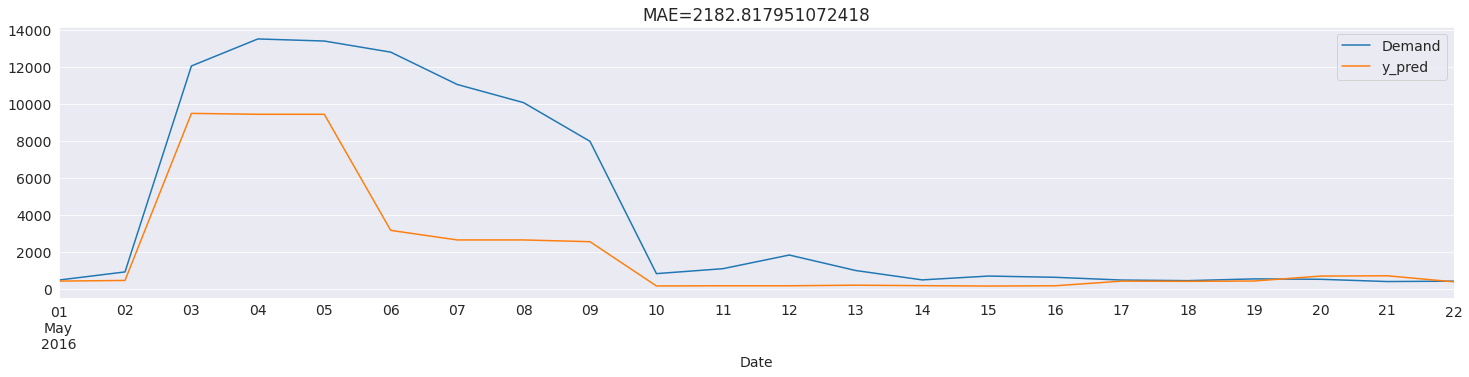

In [122]:
y_true = test_y.groupby(['SKU_id','Date']).agg({'Demand':'sum'}).reset_index().set_index('Date')

# WAPE for sku 1
qlt , _ = qualityMAE(y_true[y_true['SKU_id']==2]['Demand'], X_test2['y_pred'])

#draw forecast and actuals
X_test2.merge(y_true[y_true['SKU_id']==2], how = 'inner', left_index = True, right_index = True)[['Demand', 'y_pred']].plot(title = 'MAE='+str(qlt))

In [95]:
#!pip install catboost

     |████████████████████████████████| 76.6 MB 59 kB/s  eta 0:00:01
     |████████████████████████████████| 47 kB 194 kB/s eta 0:00:01
